In [1]:
import torch
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

In [2]:
# Process input data:
raw3s = np.loadtxt('data/three.txt')
raw8s = np.loadtxt('data/eight.txt')
X = np.vstack((raw3s, raw8s))
n = len(X)
D= len(X[0])

In [3]:
def visualize(img):
    # make the images as grid
    generated_img = torch.from_numpy(img.reshape(16, 16))
    generated_img = make_grid(generated_img.T)

    plt.imshow(generated_img.permute(1, 2, 0))
    plt.show()

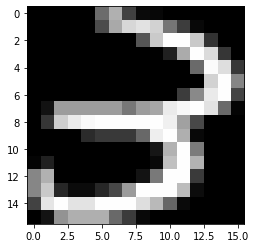

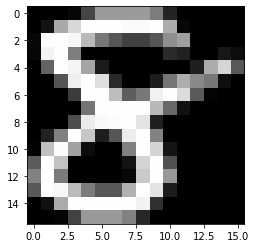

In [4]:
visualize(raw3s[0]/256)
visualize(raw8s[0]/256)

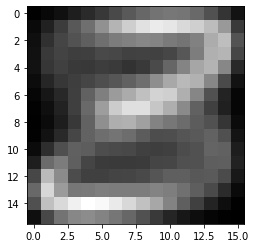

In [5]:
y = np.mean(X, axis=0)
visualize(y/np.max(y))

In [6]:
X = X - np.outer(np.ones(n), y)
S = (X.T@X)/(n-1)
print(S[0:6][0:6])

[[ 5.91672932e+01  1.42149436e+02  2.86820175e+01 ...  7.74107143e+01
   1.45341479e+01  3.97869674e-02]
 [ 1.42149436e+02  8.78938791e+02  3.74137312e+02 ...  4.01587550e+02
   1.26541873e+02  4.45093985e-01]
 [ 2.86820175e+01  3.74137312e+02  1.08290586e+03 ...  2.51275345e+02
   8.10344298e+01 -1.43796992e-02]
 [-7.17857143e+00  2.41277820e+01  5.55226880e+02 ...  1.50949261e+02
   5.89413659e+01 -3.10902256e-02]
 [-1.43358396e+01 -8.71278195e+01  3.37243108e+01 ...  9.48320802e+01
   3.12857143e+01 -3.25814536e-02]
 [-9.85714286e+00 -6.45579449e+01 -5.19807018e+01 ... -1.44472682e+01
  -3.24962406e-01 -2.19047619e-02]]


[237155.24629049 145188.35268683]


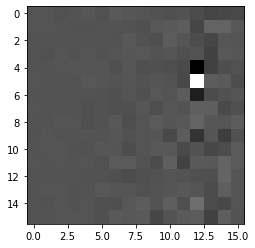

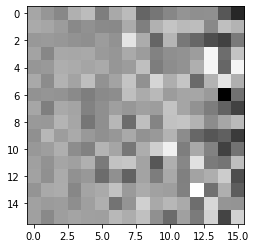

In [7]:
evals, evects = np.linalg.eig(S)
print(evals[:2])
visualize((evects[0] - np.min(evects[0]))/np.max(evects[0] - np.min(evects[0])))
visualize((evects[1] - np.min(evects[1]))/np.max(evects[1] - np.min(evects[1])))

In [8]:
V = np.vstack((evects[0], evects[1]))
proj = X@V.T
print(proj[0])
print(proj[len(raw3s)])

[-98.56726107  34.33680068]
[51.94283483 19.5940185 ]


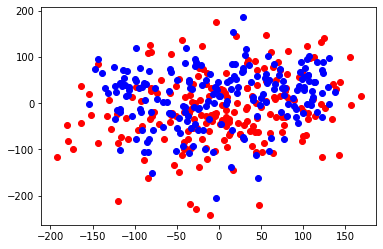

In [9]:
plt.plot(proj[:200,0], proj[:200,1], 'ro')
plt.plot(proj[200:,0], proj[200:,1], 'bo')
plt.show()

# Q-Learning

In [10]:
Q = np.zeros((2,2))  # Because states and actions so simple, just let Q[s,a] be Q(s,a)
r = [1,0]  # reward vector -- 0 corresponds to move and 1 to stay to satisfy moves breaking ties
alpha = .5  # Learning rate alpha
gamma = .8  # Discount factor gamma
num_iter = 200

for i in range(num_iter):
    for s in range(2):
        for a in range(2):
            Q[s, a] = (1-alpha)*Q[s, a] + alpha*(r[a] + gamma*np.amax(Q[(s+a+1)%2,:]))
print(Q)

[[5. 4.]
 [5. 4.]]


In [11]:
Q = np.zeros((2,2))  # Because states and actions so simple, just let Q[s,a] be Q(s,a)
r = [0,1]  # reward vector flipped from above because ties aren't stupid
alpha = .5  # Learning rate alpha
gamma = .8  # Discount factor gamma
epsilon = .5
num_iter = 200

for i in range(num_iter):
    for s in range(2):
        for a in range(2):
            if np.random.rand(1) >= epsilon:
                Q[s, a] = (1-alpha)*Q[s, a] + alpha*(r[a] + gamma*np.amax(Q[(s+a)%2,:]))
            else:
                rand_act = 0 if np.random.rand(1) >= .5 else 1
                Q[s, a] = (1-alpha)*Q[s, a] + alpha*(r[a] + gamma*Q[(s+a)%2,rand_act])
print(Q)

[[3.18473737 4.20466702]
 [2.94109281 4.27344138]]


## Bellman Derivation:
We can use the Bellman equations to get
$$ Q(s,a) = r_a + \gamma Q(s',\pi^*(s')) $$
where $ s'=s $ if the action is to stay, and $ s+1$ mod $ 2 $ otherwise. Using that 
$$ \pi^*(s) = \text{argmax}_a Q(s,a) $$
we can write up the system of equations
$$ Q(0, 0) = 1 + \gamma\max\{Q(0, 0), Q(0, 1)\} $$
$$ Q(0, 1) = \gamma\max\{Q(1, 0), Q(1, 1)\} $$
$$ Q(1, 0) = 1 + \gamma\max\{Q(1, 0), Q(1, 1)\} $$
$$ Q(1, 1) = \gamma\max\{Q(0, 0), Q(0, 1)\} $$
This system is very simple, so we can directly solve it. Say $ Q(0,0)\geq Q(0,1) $. Then $ Q(0, 0) = 1 + \gamma Q(0, 0) \implies Q(0,0)=5 $ for $ \gamma=.8 $, and $ Q(1,1)=4 $, so we have after plugging in
$$ Q = \begin{bmatrix} 5&4\\ 5&4 \end{bmatrix}. $$
If $ Q(0,0) < Q(0,1) $, we have $ Q(0,0) = 1 + \gamma Q(0,1) = 1 + \gamma^2 \max\{ Q(1,0), \gamma Q(0, 1) \} $. Because $ Q(0,1) \neq \gamma^2 Q(0,1) $, we have $ \gamma Q(0,1) = \gamma^2 Q(1,0) \implies Q(0,1) = \gamma Q(1,0) $. Nesting the above argument for state 1, we see this gives
$$ Q = \begin{bmatrix} 4&5\\ 4&5 \end{bmatrix}. $$
Because we start at state $ 0 $, we see the true $ Q $-table is 
$$ Q = \begin{bmatrix} 5&4\\ 5&4 \end{bmatrix}. $$